<a href="https://colab.research.google.com/github/Jarvis-X/Swarms-Course-Projects/blob/main/SwarmsHW3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Policy iteration and Value iteration

* Fisrt block: setup and parameter initializations

* Second block: evaluating the value function of a future state

* Third block: implementation of policy evaluation, tested with 2 robots in a 6x6 environment. γ is set to `0.2` to avoid overflow. The visualization represents the value function of all possible states robots.

  Each non-goal step grants a penalty of -1. Thus, the robots seek to reach the goal in a number of steps as low as possible. Goals are encouraged by assigning a reward of 0. Collisions are avoided by assigning a high penalty as the action takes the current states to one that incurs collision. 

  The major drawback of the policy iteration is the requirement to have the value function over all the states evaluated thoroughly before updatin (as is for a basic dynamic programming algorithm.) The largest test case I could assess is 2 robots in a 16x16 areana on Colab with the policy iteration algorithm. Larger state space simply crashes the runtime for the high space complexity. A better choice of algorithm should be a stochastic one instead of deterministic.

* Forth block: implements the value iteration algorithm, which beats the performance of policy iteration algorithm by more than 96% in the case of 2 robots in a 16x16 areana (30 seconds vs 800 seconds) in runtime. Since the 2-robot scenarios are the case where one can visually interpret the results, I chose to compare the two algorithms in this scenario. It finds the best value function at each sweep. Once the value function is stable, a policy is extracted greedily from the value function.

In the case of a big areana and a large number of robots (5 robots in 10 x 10), the space complexity increases exponetially with the number of robots to take up the entire RAM, which means both methods are not scalable.

In the case of a small areana loading a large number of robots (5 robots in 5 x 5), collision dominates the behavior of robots. A smart idea may be programmatically excluding the states of collision to reduce the state space and the corresponding action space.

In [ ]:
import numpy as np
import time
import matplotlib.pyplot as plt
import sys

# define a timeout
timeout = 500

# number of robots
num_robots = 2

# reward of each move
r = -1

# reward of collision
r_n_MAX = -100

# reward of reaching goal
r_p_MAX = 0

# random seed
np.random.seed(int(time.time_ns()%2**24))

# Grid exporation
UP = int(0); DOWN = int(1); RIGHT = int(2); LEFT = int(3); 
STAY = int(-1) # only at the destination can the robot stay
actions_single_robot = [UP, DOWN, RIGHT, LEFT]
default_total_possible_actions = len(actions_single_robot)**num_robots

rows = int(15)
cols = int(15)

# parameters
theta = 0.001
gamma = 0.2
num_states = (rows*cols)**num_robots

# state of the explorer enumerated from 1 to row x cols -2
def init_single_robot_random_state(rows: int, cols: int) -> int:
    state = int(np.random.choice(range(rows*cols - 2)) + 1)
    return state

# initialize states
states = [init_single_robot_random_state(rows, cols) for _ in range(num_robots)]

# if a robot is at a state, how an action changes its state
def single_robot_state_action_to_newstate(s: int, action: int, rows: int, cols: int) -> int:
    if action == UP:
        # print("UP")
        if s in range(0, cols):
            sprime = s
        else:
            sprime = s - cols
    elif action == DOWN:
        # print("DOWN")
        if s in range((rows-1)*cols, rows*cols):
            sprime = s
        else:
            sprime = s + cols
    elif action == LEFT:
        # print("LEFT")
        if s in range(0, cols*rows, cols):
            sprime = s
        else:
            sprime = s - 1
    elif action == RIGHT:
        # print("RIGHT")
        if s in range(cols-1, cols*rows, cols):
            sprime = s
        else:
            sprime = s + 1
    else:
        raise Exception("wrong action!")
        # print("STAY")
        
    # print(s)
    return int(sprime)


"""
policy evaluation
   V is the multi-dimensional value map, flattened to an 1-D array.
   The value extracting is just like getting the value of a decimal given its 
   digits. Only difference is that here we are not dealing with decimals, but 
   (rows*cols)-als. 

   Example:
    If we want to see the value of state s = (a, b, c, d), meaning that num_robots = 4, 
    then the corresponding index s in V is ind_s = a*(rows*cols)**(num_robots-1) + 
                                                   b*(rows*cols)**(num_robots-2) +
                                                   c*(rows*cols)**(num_robots-3) +
                                                   d*(rows*cols)**(num_robots-4).
    Thus v = V[ind_s]
"""
# helper function that implements the philosophy above
def from_state_to_index(rows: int, cols: int, num_robot: int, states: list) -> int:
    ind_s = int(0)
    layer_thiccness = int(rows*cols)
    for depth in range(len(states)):
        ind_s += int(states[depth]*layer_thiccness**(num_robot - depth - 1))
    return ind_s

# and of course, its inverse
def from_index_to_state(rows: int, cols: int, num_robot: int, ind_s: int) -> list:
    states = []
    remnant = ind_s
    layer_thiccness = int(rows*cols)
    for i in range(num_robot):
        s = remnant % layer_thiccness
        remnant //= layer_thiccness
        states.insert(0, s)
    return states

# similarly, we need to apply the philosophy on the actions
def from_action_to_index(num_robot: int, actions: list) -> int:
    ind_a = int(0)
    layer_thiccness = int(4)
    for depth in range(len(actions)):
        ind_a += int(actions[depth]*layer_thiccness**(num_robot - depth - 1))
    return ind_a

# and of course, its inverse
def from_index_to_action(num_robot: int, ind_a: int) -> list:
    actions = []
    remnant = ind_a
    layer_thiccness = int(4)
    for i in range(num_robot):
        a = remnant % layer_thiccness
        remnant //= layer_thiccness
        actions.insert(0, a)
    return actions

In [ ]:
def cal_future_reward(states, actions, rows, cols, V, gamma) -> float:
    future_reward = 0
    new_states = []
    action_index = 0
    for single_robot_state in states:
        sprime = single_robot_state_action_to_newstate(single_robot_state, actions[action_index], rows, cols)
        if (sprime in new_states) and (sprime != int(0)) and (sprime != int(rows*cols-1)):
            future_reward += r_n_MAX + gamma*V[sprime]
        elif (sprime == int(0)) or (sprime == int(rows*cols-1)):
            future_reward += r_p_MAX*((sprime == int(0)) + (sprime == int(rows*cols-1))) + gamma*V[sprime]
        else:
            future_reward += r + gamma*V[sprime]
        new_states.append(sprime)
        action_index += 1
    return future_reward


Evaluated!!
[[[-42.16996435 -72.35227002 -49.79995873 ... -50.6821092  -28.0752473
   -49.39423076]
  [-74.49204485 -59.51942135 -72.45374846 ... -37.12701722 -30.2313134
   -43.25637456]
  [-29.50198708 -83.41556896 -43.6071129  ... -40.50546248 -37.9965893
   -33.40338802]
  ...
  [-36.09741603 -21.71767302 -50.02711992 ... -40.68361494 -31.39286202
   -39.06392296]
  [-43.94863254 -36.2204692  -34.59599634 ... -40.31941372 -26.68372152
   -23.28822942]
  [-39.30365564 -43.9346925  -42.50732961 ... -29.86816709 -34.52804845
   -35.66230526]]

 [[-61.74078312 -72.33833605 -62.66992316 ... -47.10469124 -45.29585069
   -36.05832948]
  [-50.35978028 -68.3085745  -49.8646978  ... -44.14898051 -38.7277085
   -38.09249957]
  [-38.66210637 -82.55223757 -45.71480839 ... -42.05969985 -47.9283737
   -40.61873511]
  ...
  [-46.3678607  -43.93383443 -46.04062067 ... -34.41347889 -33.53613987
   -29.84140748]
  [-39.37661663 -41.10206706 -37.93603775 ... -33.40139321 -37.56693374
   -37.90156415]


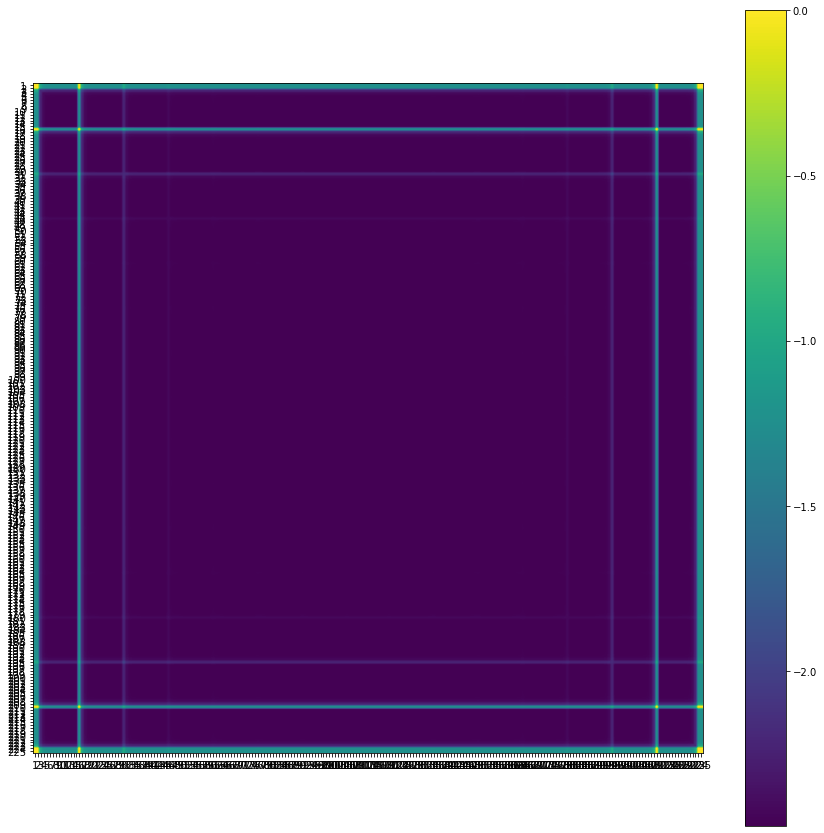

In [ ]:

# policy evaluation: value function V initialized outside
def policy_evaluation(policy, rows: int, cols: int, V: np.array, theta, gamma):
    time_begin = time.time()
    while True:
        delta = 0
        if time.time() - time_begin >= timeout:
            print("Time out when evaluating a policy!!")
            return

        for multi_robot_state in range(num_states):
            v = V[multi_robot_state]

            separate_states = from_index_to_state(rows, cols, num_robots, multi_robot_state)
            Vs = 0
            for multi_robot_action in range(default_total_possible_actions):
                separate_actions = from_index_to_action(num_robots, multi_robot_action)
                # now we have the state and the action of each robot, get the 
                # new state of each robot and calculate the reward
                future_reward = cal_future_reward(separate_states, separate_actions, rows, cols, V, gamma)
                Vs += future_reward*policy(multi_robot_state, multi_robot_action)
            V[multi_robot_state] = Vs

            delta = max(delta, abs(v - Vs))
        if delta < theta:
            print("Evaluated!!")
            print(V.reshape((rows, cols, -1)))
            return V

def policy_improvement(evolving_policy, rows, cols, V_evolving, gamma):
    policy_stable = True
    for multi_robot_state in range(num_states):
        # get the best action based on current policy
        best_action = np.argmax(evolving_policy.pi_matrix[multi_robot_state])

        # see if there is actually a better choice
        separate_states = from_index_to_state(rows, cols, num_robots, multi_robot_state)
        future_rewards = []
        for multi_robot_action in range(default_total_possible_actions):
            separate_actions = from_index_to_action(num_robots, multi_robot_action)
            # now we have the state and the action of each robot, get the 
            # new state of each robot and calculate the reward
            future_reward = cal_future_reward(separate_states, separate_actions, rows, cols, V_evolving, gamma)
            future_rewards.append(future_reward)
        
        pi_action = np.argmax(future_rewards)
        evolving_policy.update_policy(multi_robot_state, pi_action)
        if int(pi_action) != int(best_action):
            policy_stable = False
    
    return policy_stable


"""
Evolving policy
"""
class Evolving_Policy():
    def __init__(self, pi_matrix):
        self.pi_matrix = pi_matrix
    def policy(self, s, a):
        return self.pi_matrix[s, a]
    def update_policy(self, s, a):
        self.pi_matrix[s] = 0.
        self.pi_matrix[s, a] = 0.99

"""-----------
initialization
-----------"""
# value function
V_evolving = np.zeros(num_states) 
pi_matrix = 0.25*np.random.random((num_states, default_total_possible_actions))
evolving_policy = Evolving_Policy(pi_matrix)
time_begin = time.time()


################################################################################
# main function
###############
while True:
    if time.time() - time_begin >= timeout*10:
        # print(evolving_policy.pi_matrix)
        print("Time out!!")
        break
    
    """--------------
    policy evaluation
    --------------"""
    policy_evaluation(evolving_policy.policy, rows, cols, V_evolving, theta=theta, gamma=gamma)
    
    """---------------
    policy improvement
    ---------------"""
    policy_stable = True
    policy_stable = policy_improvement(evolving_policy, rows, cols, V_evolving, gamma)

    if policy_stable:
        print("policy found")
        print(evolving_policy.pi_matrix)
        break

################################################################################
# visualization
###############
from matplotlib import colors
print(evolving_policy.pi_matrix)
V_evolving = V_evolving.reshape((rows*cols, rows*cols))
# # create discrete colormap
cmap = colors.ListedColormap(['red', 'blue'])
bounds = [-10,10,20]
norm = colors.BoundaryNorm(bounds, cmap.N)

fig, ax = plt.subplots(figsize=(rows,cols))
im = ax.imshow(V_evolving)

# draw gridlines
# ax.grid(which='major', axis='both', linestyle='-', color='k', linewidth=2)

# col_labels = [int(100/nx)*i for i in range(nx+1)]
# row_labels = [int(100/ny)*i for i in range(ny+1)]

# plt.xticks([1]+col_labels, [1]+col_labels)
# plt.yticks(row_labels, [label/25 for label in row_labels])

ax.set_xticks(np.arange(rows*cols));
ax.set_yticks(np.arange(rows*cols));
ax.set_xticklabels(np.arange(1, rows*cols+1, 1))
ax.set_yticklabels(np.arange(1, rows*cols+1, 1))

plt.colorbar(im)
plt.show()

In [ ]:
time_begin = time.time()

# value function
V_iterative = np.zeros(num_states)

while True:
    if time.time() - time_begin >= timeout*10:
        # print(evolving_policy.pi_matrix)
        print("Time out!!")
        break
    
    delta = 0
    
    for multi_robot_state in range(num_states):
        # get the current value function
        v = V_iterative[multi_robot_state]

        # obtain the maximum future reward
        separate_states = from_index_to_state(rows, cols, num_robots, multi_robot_state)
        Vs = -1E20
        for multi_robot_action in range(default_total_possible_actions):
            separate_actions = from_index_to_action(num_robots, multi_robot_action)
            # now we have the state and the action of each robot, get the 
            # new state of each robot and calculate the reward
            future_reward = cal_future_reward(separate_states, separate_actions, rows, cols, V_iterative, gamma)
            if future_reward > Vs:
                Vs = future_reward
        V_iterative[multi_robot_state] = Vs

        delta = max(delta, abs(v - Vs))

    if delta < theta:
        print("Evaluated!!")
        break
        # print(V_iterative.reshape((rows, cols, -1)))

plot = True
if plot:
    ################################################################################
    # visualization
    ###############
    from matplotlib import colors
    V_iterative = V_iterative.reshape((rows*cols, rows*cols))
    # # create discrete colormap
    cmap = colors.ListedColormap(['red', 'blue'])
    bounds = [-10,10,20]
    norm = colors.BoundaryNorm(bounds, cmap.N)

    figi, axi = plt.subplots(figsize=(rows,cols))
    imi = axi.imshow(V_iterative)

    # draw gridlines
    # ax.grid(which='major', axis='both', linestyle='-', color='k', linewidth=2)

    # col_labels = [int(100/nx)*i for i in range(nx+1)]
    # row_labels = [int(100/ny)*i for i in range(ny+1)]

    # plt.xticks([1]+col_labels, [1]+col_labels)
    # plt.yticks(row_labels, [label/25 for label in row_labels])

    axi.set_xticks(np.arange(rows*cols));
    axi.set_yticks(np.arange(rows*cols));
    axi.set_xticklabels(np.arange(1, rows*cols+1, 1))
    axi.set_yticklabels(np.arange(1, rows*cols+1, 1))

    plt.colorbar(imi)
    plt.show()

Evaluated!!
